# Transfer learning

Transfer learning reduces the training time and data needed to achieve a custom task. It takes a CNN that has been pre-trained (typically ImageNet), removes the last fully-connected layer and replaces it with our custom fully-connected layer, treating the original CNN as a feature extractor for the new dataset. Once replaced the last fully-connected layer we train the classifier for the new dataset.

## Image classification with transfer learning

In [ ]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import optimizers
import numpy as np
from keras.layers.core import Lambda
from keras import backend as K
from keras import regularizers
from keras.applications.vgg16 import VGG16
from keras.layers import Input, Flatten, Dense, Dropout
from keras.models import Model, Sequential
from keras.optimizers import SGD
from keras.utils import np_utils


def normalize(X_train,X_test):
        #this function normalize inputs for zero mean and unit variance
        # it is used when training a model.
        # Input: training set and test set
        # Output: normalized training set and test set according to the trianing set statistics.
        mean = np.mean(X_train,axis=(0,1,2,3))
        std = np.std(X_train, axis=(0, 1, 2, 3))
        X_train = (X_train-mean)/(std+1e-7)
        X_test = (X_test-mean)/(std+1e-7)
        return X_train, X_test
      


## Data preprocessing

In [ ]:
import cv2

(x_train_rgb, y_train), (x_test_rgb, y_test) = cifar10.load_data()
print(x_train_rgb.shape)


x_train = np.array([cv2.resize(img,(75,75)) for img in x_train_rgb[:,:,:,:]])
x_test = np.array([cv2.resize(img,(75,75)) for img in x_test_rgb[:,:,:,:]])
print(x_train.shape)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train, x_test = normalize(x_train, x_test)

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

learning_rate = 1e-4
lr_decay = 1e-6
lr_drop = 20
batch_size = 32
epochs = 25

'''def lr_scheduler(epoch):
  return learning_rate * (0.5 ** (epoch // lr_drop))
reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)'''

(50000, 32, 32, 3)
(50000, 75, 75, 3)


## Model customization

In [ ]:
from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint


img_rows, img_cols, img_channel = 75, 75, 3
weight_decay = 0.0005

base = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))
#for layer in base.layers:
#    layer.trainable = False

top_model = Sequential()
top_model.add(Flatten(input_shape=base.output_shape[1:]))
top_model.add(Dense(512, activation='relu',kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(weight_decay)))
top_model.add(Dense(10, activation='softmax'))

model = Model(inputs=base.input, outputs=top_model(base.output))

ssgd = optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)
#ssgd = optimizers.Adam(lr=learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=ssgd,metrics=['accuracy'])

model.summary()

datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images
        # (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)
history = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),callbacks=[reduce_lr],verbose=2)


Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 2s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75, 75, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 75, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 75, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 37, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 37, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 37, 128)       147584    
_____

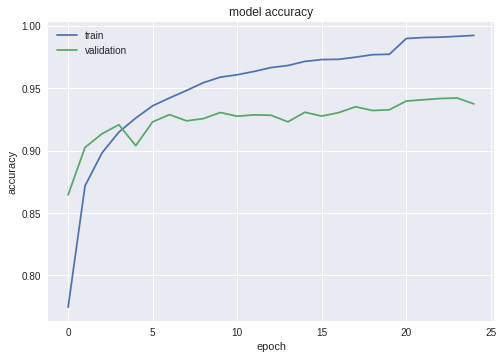

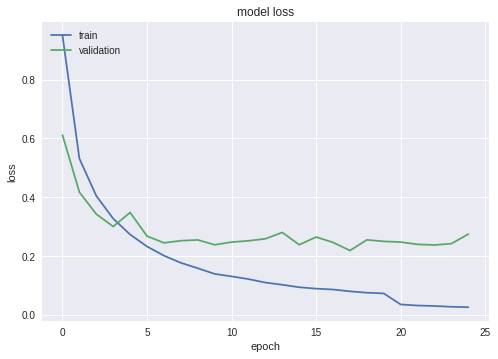

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
 model.save_weights('/content/drive/My Drive/deep_color/RGB/vgg16_RGB_25.h5')

In [ ]:
predicted_x = model.predict(x_test,batch_size= 50)
residuals = np.argmax(predicted_x,1)!=np.argmax(y_test,1)
loss = sum(residuals)/len(residuals)
print("the validation 0/1 loss is: ",loss)

the validation 0/1 loss is:  0.0624


In [ ]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 16s 2ms/step
Test loss: 0.27505670336410404
Test accuracy: 0.9376


In [ ]:
import sklearn.metrics as metrics

y_pred_ohe = model.predict(x_test,batch_size= 32)  # shape=(n_samples, 12)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)
y_test = np.argmax(y_test,axis = 1)
confusion_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_labels)

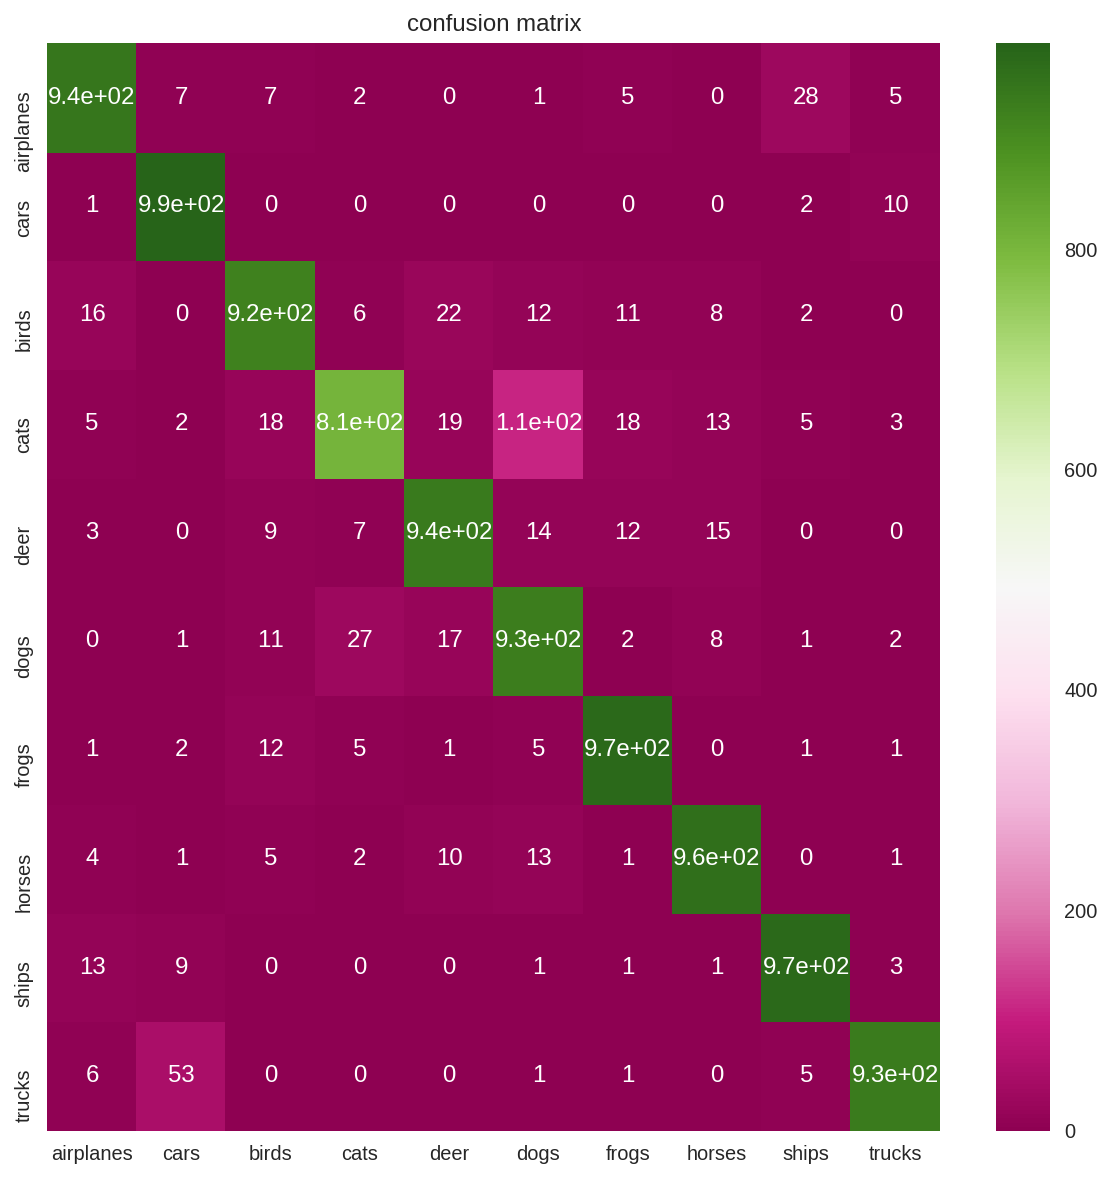

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns;sns.set()
classes = ['airplanes' , 'cars' , 'birds' , 'cats' , 'deer' , 'dogs' , 'frogs' , 'horses' , 'ships' , 'trucks' ]
%config InlineBackend.figure_format = 'retina'
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix,cmap = "PiYG", annot = True , xticklabels=classes,
            yticklabels=classes)
plt.title("confusion matrix")
plt.show()

# Multi output classification

* Multi-output classification - creating multiple sets of fully-connected heads at the end of the network 
* The network can then predict a set of class labels for each head, making it possible to learn disjoint label combinations

In [ ]:
from keras.layers import Dense, Input
from keras.models import Model

# creating model
inputs = Input(shape = (784,))
dense1 = Dense(512, activation = 'relu')(inputs)
dense2 = Dense(128, activation = 'relu')(dense1)
dense3 = Dense(32, activation = 'relu')(dense2)

# create classification output
classification_output = Dense(10, activation = 'softmax')(dense3)

# use output from dense layer 3 to create autoencder output
up_dense1 = Dense(128, activation = 'relu')(dense3)
up_dense2 = Dense(512, activation = 'relu')(up_dense1)
decoded_outputs = Dense(784)(up_dense2)

In [ ]:
model = Model(inputs, [classification_output,decoded_outputs])
model.summary()

In [ ]:
m = 256
n_epoch = 25
model.compile(optimizer='adam', loss=['categorical_crossentropy', 'mse'], loss_weights = [1.0, 0.5], metrics = ['accuracy'])
model.fit(output_X_train,[Y_train, output_X_train], epochs=n_epoch, batch_size=m, shuffle=True)

# Image Segmentation

In [ ]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model, Sequential

## Building the Convolution Block

In [ ]:
def convolution_operation(entered_input, filters=64):
    # Taking first input and implementing the first conv block
    conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    act1 = ReLU()(batch_norm1)
    
    # Taking first input and implementing the second conv block
    conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
    batch_norm2 = BatchNormalization()(conv2)
    act2 = ReLU()(batch_norm2)
    
    return act2

## Encoder and Decoder Blocks

In [ ]:
def encoder(entered_input, filters=64):
    # Collect the start and end of each sub-block for normal pass and skip connections
    enc1 = convolution_operation(entered_input, filters)
    MaxPool1 = MaxPooling2D(strides = (2,2))(enc1)
    return enc1, MaxPool1

In [ ]:
def decoder(entered_input, skip, filters=64):
    # Upsampling and concatenating the essential features
    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input)
    Connect_Skip = Concatenate()([Upsample, skip])
    out = convolution_operation(Connect_Skip, filters)
    return out

## Unet Model

In [ ]:
def U_Net(Image_Size):
    # Take the image size and shape
    input1 = Input(Image_Size)
    
    # Construct the encoder blocks
    skip1, encoder_1 = encoder(input1, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    skip4, encoder_4 = encoder(encoder_3, 64*8)
    
    # Preparing the next block
    conv_block = convolution_operation(encoder_4, 64*16)
    
    # Construct the decoder blocks
    decoder_1 = decoder(conv_block, skip4, 64*8)
    decoder_2 = decoder(decoder_1, skip3, 64*4)
    decoder_3 = decoder(decoder_2, skip2, 64*2)
    decoder_4 = decoder(decoder_3, skip1, 64)
    
    out = Conv2D(1, 1, padding="same", activation="sigmoid")(decoder_4)

    model = Model(input1, out)
    return model

## Finalize your model

In [ ]:
input_shape = (160, 160, 3)
model = U_Net(input_shape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 160, 160, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 160, 160, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")

# Task to Perform 
  * Use Oxford pet dataset for this particular task of image segmentation - https://www.robots.ox.ac.uk/~vgg/data/pets/
  * Classify CIFAR10 dataset with pretrained models - VGG16, ResNet50, DenseNet121 and analyze the performance 
  * Use Apparel images dataset and train multiple output CNN model to classify each dress image's category and color
 
